# Entorno de trabajo: Crear un dataset de noticias de prensa a partir del motor de búsqueda Sophia

Este notebook muestra una manera de extraer noticias desde el motor de búsqueda de _Sophia_, a partir de una **palabra clave**, un **país** y un **periodo de tiempo**.


_Sophia_ es un proyecto I+i+D desarrollado en la Universidad Austral de Chile desde 2019. El motor de búsqueda se encuentra en fase de mejoramiento continuo. Por cualquier pregunta o problema técnica con este notebook, no dudar en contactarme por Discord (@MatthieuVernier) o por correo mvernier@inf.uach.cl.

## 0. Librerías útiles

- Elasticsearch es el motor de búsqueda utilizado por Sophia
- Requiere la instalación del paquete elasticsearch

In [1]:
!python -V

Python 3.9.7


In [2]:
!pip install elasticsearch==7.16.3

     -------------------------------------- 385.7/385.7 kB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 140.4/140.4 kB ? eta 0:00:00


In [3]:
import elasticsearch
from datetime import datetime

In [4]:
elasticsearch.__version__

(7, 16, 3)

## 1. Parámetros de la búsqueda

In [5]:
country="chile"
from_="2021-12-20"
to_="2021-12-26"
media_outlets=["elllanquihue","elaustral","laestrelladechiloe","elheraldoaustral","radiosago",
               "elrepuertero","elvacanudo","elhuemul","seminariolocal","elquellonino","elinsular",
               "radiopudeto","radioacogida","elcalbucano","segundos33",
               "prensadelestuario","fresiaahora","soychiloe"]

keyword=""
simple_keyword=False

Características del motor de búsqueda:  
- El formato de las fechas es: YYYY-MM-DD
- El motor de búsqueda incluye noticias por distintos paises, pero se recomienda utilizar "chile" por el momento.
- El motor de búsqueda incluye datos entre el año 2000 y el año 2021.

## 2. Parámetros de conexión al motor de búsqueda de Sophia

In [6]:
IP = "search.sophia2.org"
PORT = 9200
USER= "elastic"
PASS= "dummy_elastic"

In [7]:
#NO MODIFICAR

es = elasticsearch.Elasticsearch(
    IP,
    #port=PORT,
    http_auth=(USER, PASS)
)

## 3. Búsqueda de noticias de prensa

- Preparación de la consulta en el formato solicitado por Elasticsearch

In [8]:
#NO MODIFICAR
match=""
if (simple_keyword):
    match="match"
else:
    match="match_phrase"

#se comenta para que pueda hacer la búsqueda sin la palabra filtrada
query = { 
    "bool": { 
      #"must": [
       # {match: { "text":keyword}}

      #],
    "filter": [
        {"range": {
      "date": {
        "gte": from_,
        "lt": to_
      }}},
        { "term":  { "country": country }},
        { "terms":  { "media_outlet": media_outlets }} 
    ]
    }  
}

- Envio de la consulta
- No se puede devolver más de 10.000 noticias. En caso de obtener 10.000 respuestas, se recomienda buscar en un periodo de tiempo más corto o modificar la consulta.

In [9]:
res = es.search(index="news", query=query, size=10000)
print("Son %d noticias encontradas..." % res['hits']['total']['value'])

Son 1496 noticias encontradas...


## 4. Guardar los datos en un dataframe Pandas y en un archivo CSV

In [12]:
import pandas as pd

data = {'id_news':[],'country':[],'media_outlet':[],'url':[],'title':[],'text':[],'date':[],'search':[]}

df = pd.DataFrame(data)  
  
for hit in res['hits']['hits']:
    id_news = hit['_source']['id_news']
    country = hit['_source']['country']
    media_outlet = hit['_source']['media_outlet']
    url = hit['_source']['url']
    title = hit['_source']['title']
    text = hit['_source']['text']
    date = hit['_source']['date']
    search = keyword
    
    new_row = {'id_news':id_news, 'country':country, 'media_outlet':media_outlet, 'url':url, 'title':title, 'text':text, 'date':date, 'search':search}
    
    df = df.append(new_row, ignore_index=True)

df

C:\Users\floje\AppData\Local\Temp\ipykernel_18764\2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\floje\AppData\Local\Temp\ipykernel_18764\2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\floje\AppData\Local\Temp\ipykernel_18764\2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\floje\AppData\Local\Temp\ipykernel_18764\2054475504.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\floje\A

,id_news,country,media_outlet,url,title,text,date,search
0,21887359.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-pu...,Cámara de Comercio Puerto Montt responde a alc...,Cabe recordar que luego que el gremio presenta...,2021-12-24,
1,21909781.0,chile,radiosago,https://www.radiosago.cl/defienden-decision-de...,Defienden decisión de no otorgar terrenos de e...,Luego que el Senador Rabindranath Quinteros em...,2021-12-24,
2,21909810.0,chile,radiosago,https://www.radiosago.cl/senador-quinteros-def...,Senador Quinteros defiende construcción de cen...,En su calidad de presidente de la comisión de ...,2021-12-24,
3,21909823.0,chile,radiosago,https://www.radiosago.cl/146-contagios-de-covi...,146 contagios de covid-19 se reportaron este s...,"Así lo informó la Seremi de Salud Los Lagos, d...",2021-12-25,
4,21909824.0,chile,radiosago,https://www.radiosago.cl/134-contagios-y-1-fal...,134 contagios y 1 fallecido dejó el covid-19 e...,"Así lo confirmó la autoridad sanitaria, detall...",2021-12-24,
...,...,...,...,...,...,...,...,...
1491,47535132.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Poesía después del incendio en la Isla,1¿Cómo están las cosas tras el incendio en Cas...,2021-12-23,
1492,47535133.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,"""El discípulo del chef"" sumará cinco nuevos pa...",En enero próximo cinco nuevos famosos llegarán...,2021-12-23,
1493,47535134.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,"""Matrix"" estrena su cuarta entrega a 22 años d...","Corría 1999, cuando una película, ""Matrix"" lle...",2021-12-23,
1494,47535137.0,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/1...,Un ejercicio nostálgico de Steven Spielberg,¿Por qué Steven Spielberg decidió hacer un rem...,2021-12-23,


In [11]:
#!pip install pandas

     --------------------------------------- 10.9/10.9 MB 15.6 MB/s eta 0:00:00
     ------------------------------------- 500.8/500.8 kB 32.7 MB/s eta 0:00:00
     --------------------------------------- 14.7/14.7 MB 38.4 MB/s eta 0:00:00


- Verifiquemos si existen noticias con la misma URL

In [13]:
df['url'].duplicated().any()

True

- Eliminar las noticias duplicadas

In [14]:
df = df.drop_duplicates(subset='url', keep='first')

In [15]:
df

,id_news,country,media_outlet,url,title,text,date,search
0,21887359.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-pu...,Cámara de Comercio Puerto Montt responde a alc...,Cabe recordar que luego que el gremio presenta...,2021-12-24,
1,21909781.0,chile,radiosago,https://www.radiosago.cl/defienden-decision-de...,Defienden decisión de no otorgar terrenos de e...,Luego que el Senador Rabindranath Quinteros em...,2021-12-24,
2,21909810.0,chile,radiosago,https://www.radiosago.cl/senador-quinteros-def...,Senador Quinteros defiende construcción de cen...,En su calidad de presidente de la comisión de ...,2021-12-24,
3,21909823.0,chile,radiosago,https://www.radiosago.cl/146-contagios-de-covi...,146 contagios de covid-19 se reportaron este s...,"Así lo informó la Seremi de Salud Los Lagos, d...",2021-12-25,
4,21909824.0,chile,radiosago,https://www.radiosago.cl/134-contagios-y-1-fal...,134 contagios y 1 fallecido dejó el covid-19 e...,"Así lo confirmó la autoridad sanitaria, detall...",2021-12-24,
...,...,...,...,...,...,...,...,...
897,22597560.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,"Francisca Valenzuela publica ""Salú"", el último...","En el primer semestre de 2022, Francisca Valen...",2021-12-20,
930,47532675.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,"Brereton: ""Ir a la Roja me hizo madurar como p...",Como una de las estrellas de la Championship d...,2021-12-23,
995,47533038.0,chile,elaustral,https://www.australosorno.cl/impresa/2021/12/2...,"Con el viejo truco de achicar el envase, Japón...",Hacer envases más pequeños mientras se siguen ...,2021-12-25,
1165,47375525.0,chile,elheraldoaustral,https://www.eha.cl/noticia/local/exposicion-na...,Exposición Nativo Arte & Oficio en Biblioteca ...,La Exposición NATIVO arte & oficio reúne a dos...,2021-12-21,


- Guardar los archivos en un CSV

In [16]:
nombre_archivo=keyword.replace(' ', '')+"_"+country+"_"+from_+"_"+to_+".csv"
print("El archivo se llama:")
print(nombre_archivo)
df.to_csv("./"+nombre_archivo)

El archivo se llama:
_chile_2021-12-20_2021-12-26.csv


- Realizar algunas consultas SQL sobre el dataset

In [18]:
from pandasql import sqldf 

In [17]:
#!pip install pandasql

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.6/1.6 MB 16.6 MB/s eta 0:00:00
     ---------------------------------------- 101.9/101.9 kB ? eta 0:00:00
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26768 sha256=a220640fa457d3ca032c98a43e3deccb3f40ea6368461ea2a2e1ad9279f38527
  Stored in directory: c:\users\floje\appdata\local\pip\cache\wheels\63\e8\ec\75b1df467ecf57b6ececb32cb16f4e86697cbfe55cb0c51f07
Successfully built pandasql


In [19]:
result = sqldf("SELECT media_outlet,count(*) FROM df GROUP BY media_outlet ORDER BY count(*) DESC")
result

,media_outlet,count(*)
0,laestrelladechiloe,86
1,elllanquihue,76
2,elaustral,75
3,radiosago,67
4,elrepuertero,54
5,elvacanudo,52
6,elheraldoaustral,44
7,elinsular,32
8,seminariolocal,14
9,radiopudeto,12


In [18]:
#!pip install pandas

In [20]:
import pandas

archivo = "_chile_2021-12-20_2021-12-26.csv"
corpus = pandas.read_csv(archivo)

In [21]:
corpus.head(5)

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date,search
0,0,21887359.0,chile,radiosago,https://www.radiosago.cl/camara-de-comercio-pu...,Cámara de Comercio Puerto Montt responde a alc...,Cabe recordar que luego que el gremio presenta...,2021-12-24,NaN
1,1,21909781.0,chile,radiosago,https://www.radiosago.cl/defienden-decision-de...,Defienden decisión de no otorgar terrenos de e...,Luego que el Senador Rabindranath Quinteros em...,2021-12-24,NaN
2,2,21909810.0,chile,radiosago,https://www.radiosago.cl/senador-quinteros-def...,Senador Quinteros defiende construcción de cen...,En su calidad de presidente de la comisión de ...,2021-12-24,NaN
3,3,21909823.0,chile,radiosago,https://www.radiosago.cl/146-contagios-de-covi...,146 contagios de covid-19 se reportaron este s...,"Así lo informó la Seremi de Salud Los Lagos, d...",2021-12-25,NaN
4,4,21909824.0,chile,radiosago,https://www.radiosago.cl/134-contagios-y-1-fal...,134 contagios y 1 fallecido dejó el covid-19 e...,"Así lo confirmó la autoridad sanitaria, detall...",2021-12-24,NaN


In [22]:
print("El total de noticias es: ",len(corpus))

El total de noticias es:  557


In [23]:
#Lista de noticias segun el corpus

lista_noticias = corpus.text.values.tolist()

In [24]:
#lista_noticias[100]

'Faltan pocos días para la Navidad y las personas están comprando los últimos regalos para estas fiestas. Para facilitar este trabajo y simplificar la vida de sus clientes, Entel ya tiene disponible su servicio de retiro en tienda en menos de una hora, en cualquier sucursal del país, para aquellas compras realizadas mediante e-commerce y canales remotos. “En Entel, hemos trabajado mucho para mejorar la experiencia de compra de nuestros clientes a través de e-commerce o nuestros canales remotos, lo que se ha traducido en altísimos niveles de satisfacción. Hace unos meses lanzamos este servicio, que ya está disponible en todo el país, y hemos recibido un feedback increíble. Por lo mismo, esperamos que sea una herramienta útil para esta Navidad, ya que las personas podrán comprar de manera muy rápida diversos productos y artefactos de telefonía”, señaló el gerente de Canales Presenciales Entel, Juan de Dios Munizaga. Delivery a nivel nacional Complementando las posibilidades de compra, En

In [29]:
#!python -m spacy download es_core_news_sm

     --------------------------------------- 12.9/12.9 MB 13.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [26]:
#!pip install pyLDAvis
#!pip install spacy
#!pip install numpy

     --------------------------------------- 11.8/11.8 MB 50.3 MB/s eta 0:00:00
     ---------------------------------------- 62.8/62.8 kB 3.5 MB/s eta 0:00:00
     -------------------------------------- 133.1/133.1 kB 7.7 MB/s eta 0:00:00
     ---------------------------------------- 450.1/450.1 kB ? eta 0:00:00
     ---------------------------------------- 42.8/42.8 kB 2.0 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 78.6 MB/s eta 0:00:00
     ---------------------------------------- 96.8/96.8 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB ? eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 43.8 MB/s eta 0:00:00
     ------------------------------------- 181.6/181.6 kB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 58.6/58.6 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 61.5/61.5 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 

In [30]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

In [34]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
#!pip install matplotlib
#!pip install gensim

In [27]:
#!python -m spacy download es_core_news_sm

In [35]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [36]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [37]:
#lista_noticias[0]

'Cabe recordar que luego que el gremio presentara un recurso de protección contra la Municipalidad de Puerto Montt en la Corte de Apelaciones y un reclamo de ilegalidad en la Contraloría por la falta de fiscalización a los vendedores ambulantes e informales en la ciudad, elñ alcalde Gervoy Paredes dio cuenta de cierta intencionalidad política para no sumarse a la mesa de trabajo interinstitucional para abordar el comercio informal. Al respecto, Eduardo Salazar, presidente de la Cámara de Comercio, Industria y Turismo afirmó que el gremio es “técnico” y vela no solo por los intereses de sus asociados, sino que también por los de la ciudad.  En esa misma línea, Salazar reiteró que la municipalidad no ha controlado a los ambulantes, lo que permite su proliferación ya que a diario se ve como más calles y veredas son tomadas para ofrecer distintos productos de manera irregular. Cabe consignar que las acciones de la Cámara de Comercio de Puerto Montt tendrán una arista administrativa en la C

In [38]:
#text_to_list(lista_noticias[0])

['gremio',
 'recurso',
 'protección',
 'reclamo',
 'ilegalidad',
 'falta',
 'fiscalización',
 'vendedores',
 'ciudad',
 'alcalde',
 'cuenta',
 'intencionalidad',
 'mesa',
 'trabajo',
 'comercio',
 'respecto',
 'presidente',
 'gremio',
 'solo',
 'intereses',
 'asociados',
 'ciudad',
 'línea',
 'municipalidad',
 'ambulantes',
 'proliferación',
 'diario',
 'calles',
 'productos',
 'manera',
 'acciones',
 'arista',
 'fin',
 'modificación',
 'ordenanza',
 'venta',
 'gremio',
 'acción',
 'tribunales',
 'organismo',
 'vez',
 'autoridades',
 'funciones',
 'ley',
 'Gervoy Paredes',
 'Eduardo Salazar',
 'recurso de protección',
 'reclamo de ilegalidad',
 'falta de fiscalización',
 'vendedores ambulantes',
 'intencionalidad política',
 'mesa de trabajo',
 'trabajo interinstitucional',
 'comercio informal',
 'productos de manera',
 'manera irregular',
 'arista administrativa',
 'venta informal',
 'gremio puertomontino',
 'acción judicial',
 'organismo público',
 'autoridades locales']

In [39]:
noticias_procesadas = []

for index, noticia in enumerate(lista_noticias):
    #print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
nan
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
nan
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
131
132
133
134
135
136
137
138
139
nan
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
nan
[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>
180
181
182
183
184
185
186
187
188
189
190
191
nan
[E1041] Expected a

In [40]:
#N = 5
#print(lista_noticias[N],"\n")
#print(noticias_procesadas[N])

Ante la tensión de ocupación de las camas críticas en la red integrada de salud regional covid-19, la Unidad de Gestión Centralizada de Camas (UGCC) trabaja para poder atender el uso de estas camas, considerando que la región de Los Lagos ha aumentado el número de casos y de hospitalizaciones por covid-19 en las últimas semanas. Y para eso se requiere descomprimir el sistema, trasladando pacientes hacia regiones con menor ocupación de camas críticas y también moviendo pacientes entre recintos al interior de la región. Desde la semana del 29 de noviembre a la fecha, son 44 los traslados de pacientes que se han realizado desde la región de Los Lagos a otras regiones y también al interior de la propia región, según explicó la Doctora María Isabel Martínez, subdirectora de Gestión Asistencial del Servicio de Salud Del Reloncaví y parte del equipo de coordinación de la red integrada de salud en la región. De los 20 traslados intrarregionales, 18 han sido de pacientes trasladados desde los d

In [41]:
id2word = corpora.Dictionary(noticias_procesadas)
id2word

In [42]:
#id2word[180]

'inscripciones'

In [43]:
texts = noticias_procesadas

In [44]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas] 

In [59]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=10, #modificar a más de 5 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [48]:
lda_model.save('./data/lda_model_textos')

In [49]:
#!pip install pprint

ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


In [50]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.006*"vida" + 0.005*"años" + 0.005*"película" + 0.004*"historia" + '
  '0.004*"año" + 0.004*"aire" + 0.004*"parte" + 0.003*"niño" + 0.003*"tiempo" '
  '+ 0.003*"telescopio" + 0.002*"forma" + 0.002*"mundo" + 0.002*"canciones" + '
  '0.002*"día" + 0.002*"nombre" + 0.002*"vez" + 0.002*"versión" + '
  '0.002*"música" + 0.002*"trabajo" + 0.002*"festival" + 0.002*"días" + '
  '0.002*"gracias" + 0.002*"origen" + 0.002*"misiles" + 0.002*"James Webb" + '
  '0.002*"padre" + 0.002*"amor" + 0.002*"horas" + 0.002*"lugar" + '
  '0.002*"momento" + 0.002*"fecha" + 0.001*"ciudad" + 0.001*"sitio" + '
  '0.001*"punto" + 0.001*"casa" + 0.001*"manera" + 0.001*"películas" + '
  '0.001*"amigos" + 0.001*"empresa" + 0.001*"función" + 0.001*"servicio" + '
  '0.001*"temporada" + 0.001*"canción" + 0.001*"realidad" + 0.001*"ruta" + '
  '0.001*"álbum" + 0.001*"reno" + 0.001*"pareja" + 0.001*"energía" + '
  '0.001*"acondicionado" + 0.001*"guerra" + 0.001*"clásico" + 0.001*"pop" + '
  '0.001*"familia" + 0.00

In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

c:\Users\floje\miniconda3\envs\myenv\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.279622 -0.094072       1        1  38.861498
8     -0.233259  0.204793       2        1  22.227347
7     -0.004476 -0.250471       3        1  11.478193
2     -0.052046 -0.047470       4        1  10.538754
4      0.074525  0.038875       5        1   4.179806
9      0.046370  0.027801       6        1   4.172552
0      0.119325  0.037120       7        1   3.799751
6      0.123951  0.031980       8        1   3.377359
5      0.097354  0.024309       9        1   0.736705
1      0.107879  0.027136      10        1   0.628036, topic_info=                       Term        Freq       Total Category  logprob  loglift
316                   niños  125.000000  125.000000  Default  30.0000  30.0000
14                 comercio   88.000000   88.000000  Default  29.0000  29.0000
283                    país  302.000000  302.000000  Default  28.0000  28.0000
182                personas  428.000000  428.000000  Default  27.0000  27.0000
299                   dosis  141.000000  141.000000  Default  26.0000  26.0000
...                     ...         ...         ...      ...      ...      ...
11958          etapa partir    0.290722    0.912492  Topic10  -7.2308   3.9265
11959  familias vulnerables    0.290722    0.912492  Topic10  -7.2308   3.9265
1674                déficit    0.568693   20.739198  Topic10  -6.5599   1.4739
1175               vivienda    0.504073   21.071687  Topic10  -6.6805   1.3374
1166                peligro    0.308376    4.744295  Topic10  -7.1719   2.3370

[496 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
8007      6  0.977324          2014
369       1  0.259104          2020
369       2  0.086368          2020
369       6  0.518208          2020
369       7  0.086368          2020
...     ...       ...           ...
2631      9  0.307391         árbol
1225      5  0.877297       árboles
1757      3  0.652424         áreas
1757      4  0.339260         áreas
5823      8  0.906784  áreas verdes

[698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 8, 3, 5, 10, 1, 7, 6, 2])

In [52]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.725091415852022

Coherence Score:  0.2814000418836187


In [53]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [56]:
start=2
limit=15
step=2

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8
10
12
14


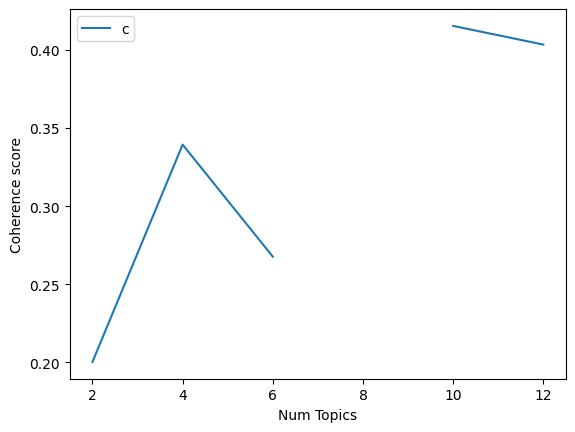

In [58]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Según el gráfico, propondría que a los 10 tópicos hay mejor coherencia

In [61]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2003
Num Topics = 4  has Coherence Value of 0.3394
Num Topics = 6  has Coherence Value of 0.2677
Num Topics = 8  has Coherence Value of nan
Num Topics = 10  has Coherence Value of 0.4154
Num Topics = 12  has Coherence Value of 0.4035
Num Topics = 14  has Coherence Value of nan


In [62]:
#Tópico más óptimo, osea donde la coherencia es mayor, en este caso en 10
optimal_model = model_list[4]